In [36]:
import pandas
import numpy as np
from numpy import mean
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
df = pandas.read_csv('data.csv')

/Users/Mr_ren/.virtualenvs/thesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = (df['QTYERROR'] / df['TOTAL']) * 100

In [4]:
df.nunique()

ITEMID           16
QTYSCHED         60
OprId            17
WORKER           13
WrkCtrId         43
CALCQTY          57
CALCSETUP         2
CALCPROC        224
WRKCTRIDCOST     14
QTYERROR          2
QTYGOOD          56
TOTAL            55
ERROR_RATE        5
dtype: int64

In [5]:
df['ERROR_RATE'].unique()

array([  0.        ,   5.88235294,  16.66666667,  14.28571429,
       100.        ])

In [6]:
df[df.QTYERROR != 0]['TOTAL'].unique()

array([17.,  6.,  7.,  1.])

In [7]:
counter = Counter(df['ERROR_RATE'])
counter

Counter({0.0: 91071,
         5.88235294117647: 166,
         16.666666666666664: 326,
         14.285714285714285: 166,
         100.0: 160})

In [8]:
df.describe()

,QTYSCHED,WORKER,CALCQTY,CALCSETUP,CALCPROC,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE
count,91889.000000,9.188900e+04,91889.000000,91889.000000,91889.000000,91889.000000,91889.000000,91889.000000,91889.000000
mean,47.205074,7.232114e+09,44.698419,0.001589,7.808776,0.008902,37.931276,37.940178,0.269687
std,997.117141,1.053060e+10,305.857957,0.039829,37.666677,0.093930,286.522036,286.521073,4.330873
min,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,-3063.000000,-3063.000000,0.000000
25%,5.000000,0.000000e+00,5.000000,0.000000,0.500000,0.000000,5.000000,5.000000,0.000000
50%,7.000000,0.000000e+00,7.000000,0.000000,1.333333,0.000000,6.000000,6.000000,0.000000
75%,20.000000,2.256542e+10,20.000000,0.000000,4.000000,0.000000,18.000000,18.000000,0.000000
max,290000.000000,2.256542e+10,20992.000000,1.000000,800.000000,1.000000,3063.000000,3063.000000,100.000000


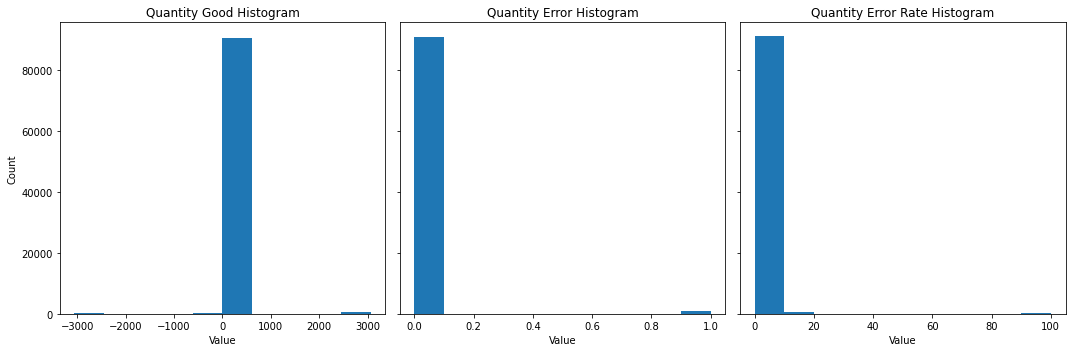

In [9]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

In [10]:
# TODO: add pie chart
def plotCategory(field):
    items = df[field].value_counts()
    plt.figure(figsize=(15, 5))
    plt.bar(items.keys(), items.values)
    plt.show()

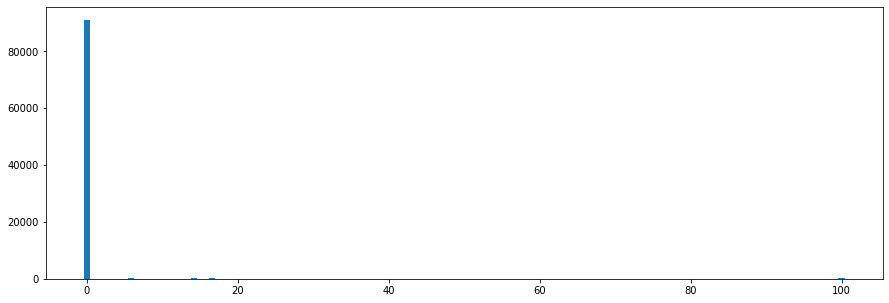

In [11]:
plotCategory('ERROR_RATE')

# preprocessing and feature engineering

In [12]:
features = ['ITEMID', 'OprId', 'WORKER', 'WrkCtrId']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrId')] = data['WrkCtrId'].astype(str)
# X = data.to_numpy()
X = data.loc[:]
y = df['ERROR_RATE'].astype(int)

In [13]:
Counter(y)

Counter({0: 91071, 5: 166, 16: 326, 14: 166, 100: 160})

In [14]:
def getMajorityClass(d):
    max_ = -1
    majority = None
    for key, val in d.items():
        if val > max_:
            majority = key
            max_ = val
    return majority

In [15]:
labelDict = Counter(y)
overSampleRate = 0.3
maj = getMajorityClass(labelDict)
majorityCount = labelDict[maj]
sampleDict = {key: int(overSampleRate * majorityCount) for key in labelDict.keys() if key != maj}

In [16]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
over = SMOTE(sampling_strategy=sampleDict, random_state=42)
under = RandomUnderSampler(sampling_strategy='majority')
model = DecisionTreeClassifier(random_state=0)
# model = RandomForestClassifier(random_state=42)
steps = [('encoding', enc), ('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# Training and validating

In [17]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)
print('cross_val_score: %.3f' % mean(scores))

cross_val_score: 0.798


In [18]:
steps = [('encoding', enc), ('over', over), ('under', under)]
resmaplePipeline = Pipeline(steps=steps)
X_res, y_res = resmaplePipeline.fit_resample(X, y)
X_train , X_test , y_train, y_test = train_test_split(X_res, y_res, random_state=0)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
print('Score for train data', dt.score(X_train, y_train))
print('Score for test data', dt.score(X_test, y_test))

Score for train data 0.8611851287907626
Score for test data 0.8520438041695948


# Feature importance

## Decision Tree feature importance

<ipython-input-19-d784cbea21ec>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


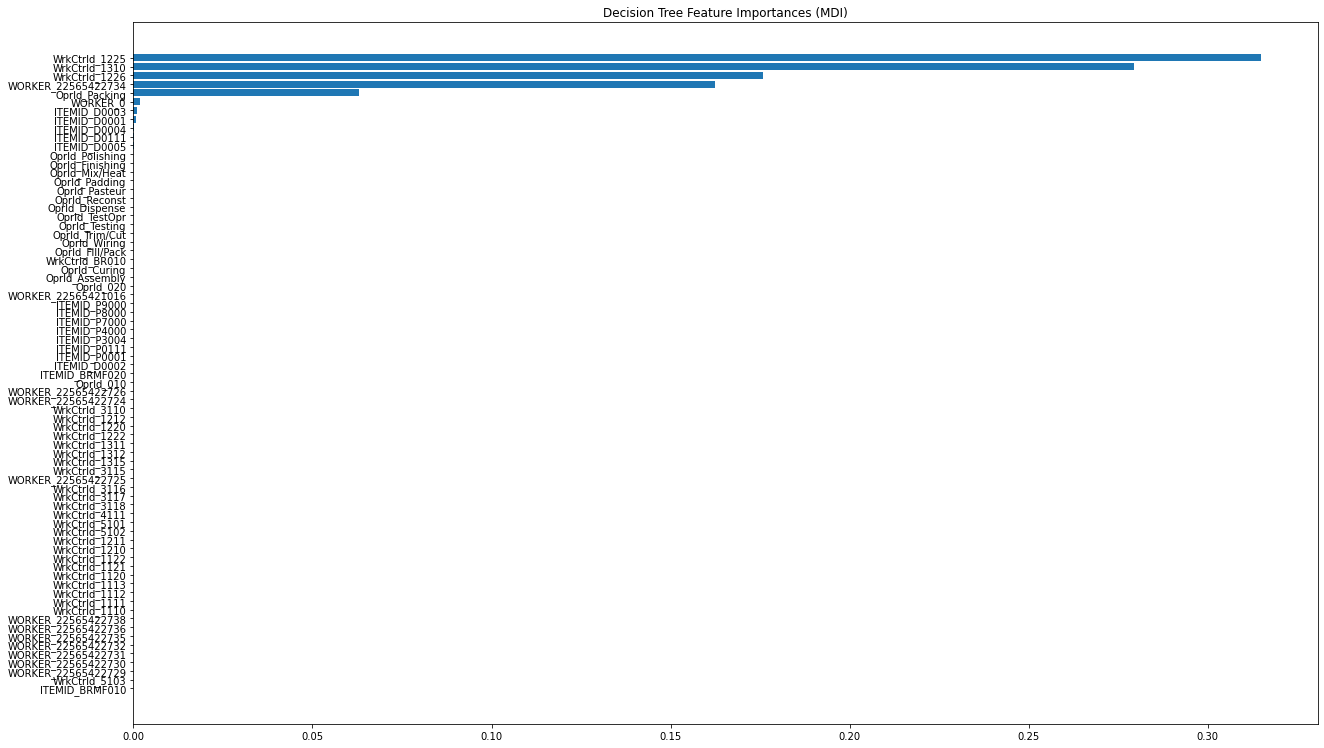

In [19]:
X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)
pipeline.fit(X_train, y_train)
feature_names = pipeline.named_steps['encoding'].get_feature_names(list(X.columns))
tree_feature_importances = (
    pipeline.named_steps['model'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances (MDI)")
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

## Permutation feature importance

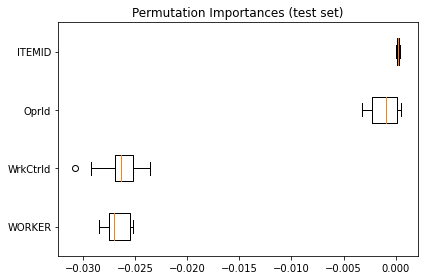

In [20]:
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Multicollinear Features

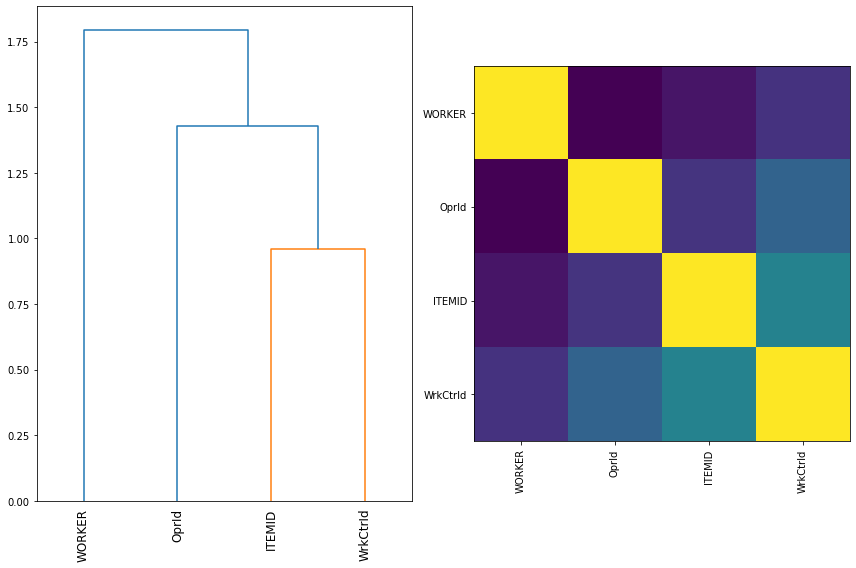

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(data.columns), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [37]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]


model.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      model.score(X_test_sel, y_test)))

TypeError: '(slice(None, None, None), [0, 1, 2])' is an invalid key

In [40]:
X_train

,ITEMID,OprId,WORKER,WrkCtrId
32541,D0003,Packing,22565422734,1222
54703,D0001,Packing,22565422734,1222
45339,D0004,Packing,0,1220
51210,D0001,Packing,0,1310
42465,D0004,Assembly,22565422729,1121
...,...,...,...,...
21243,D0001,Testing,0,1226
45891,D0004,Assembly,22565422731,1211
42613,D0004,Testing,0,1315
43567,D0004,Finishing,0,1310
